# Prepare input to AutoSort

In this tutorial, we demonstrate how to train a AutoSort model with early-stage recordings and validate its performance.

For explanatory data analysis, we provide two days' recording on April 11th and April 16th, which can be downloaded here.

In [2]:
from autosort_neuron import *

### First, we need to define the geometry of the high-density probe

In [3]:
positions=np.array([
                [150, 250], ### electrode 1 x,y
                [150,200], ### electrode 2 x,y
                [50, 0], ### electrode 3 x,y
                [50, 50],
                [50, 100], 
                [0, 100],
                [0, 50], 
                [0, 0],
                [650, 0], 
                [650, 50],
                [650, 100], 
                [600, 100],
                [600, 50], 
                [600, 0],
                [500, 200],
                [500, 250],
                [500, 300],
                [450, 300],
                [450, 250], 
                [450, 200],
                [350, 400], 
                [350, 450],
                [350, 500], 
                [300, 500],
                [300, 450], 
                [300, 400], 
                [200, 200],
                [200, 250],
                [200, 300],
                [150, 300]
                    ])

(<matplotlib.collections.PolyCollection at 0x7f7a14d03be0>, None)

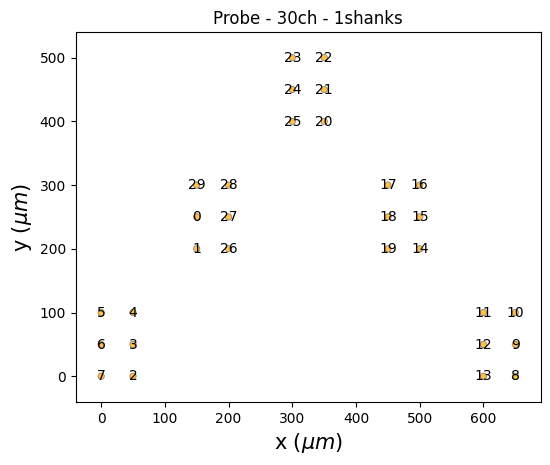

In [3]:
mesh_probe = create_mesh_probe(positions=positions,num_all_channels=positions.shape[0])
plot_probe(mesh_probe,with_device_index=True)

### Next, we load raw data recorded through Intan system. We read two days' recording on April 11th and April 16th, concatenate them.

In [31]:
### raw data path
raw_data_path = './raw_data/'

### file folder name to read
date_id_all=['0411','0416'] 
save_folder_name = '_'.join(date_id_all)

### processed data path
data_folder_all = f'./processed_data/Ephys_concat_{save_folder_name}/'


sorting_method="mountainsort"
sorting_save_path = data_folder_all + sorting_method + '/'


In [11]:
recording_concat, day_length = read_data_folder(data_folder_all, date_id_all, raw_data_path, mesh_probe, )

### bandpass filter and common reference

freq_max=3000
freq_min=300

recording_f = st.bandpass_filter(recording_concat, freq_min=freq_min, 
                                                   freq_max=freq_max)
recording_cmr = st.common_reference(recording_f, reference='global',operator='average')


./raw_data/0411/m10411_230411_220351.rhd

Reading Intan Technologies RHD2000 Data File, Version 3.2

n signal groups 11
Found 32 amplifier channels.
Found 3 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 1 board digital input channel.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 1800.000 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 55.1 seconds
downsampling to 10000


100%|██████████| 32/32 [00:52<00:00,  1.65s/it]


write_binary_recording with n_jobs = 1 and chunk_size = None
./raw_data/0416/0416_final_230416_215325.rhd

Reading Intan Technologies RHD2000 Data File, Version 3.2

n signal groups 11
Found 32 amplifier channels.
Found 3 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 1 board digital input channel.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 1800.000 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 56.9 seconds
downsampling to 10000


100%|██████████| 32/32 [00:52<00:00,  1.63s/it]


write_binary_recording with n_jobs = 1 and chunk_size = None
write_binary_recording with n_jobs = 1 and chunk_size = None
BinaryFolderRecording: 30 channels - 1 segments - 10.0kHz - 3600.000s
Num. channels = 30
Sampling frequency = 10000 Hz
Num. timepoints seg0= 1


### We perform MountainSort spike sorting on the concatenated data.

In [12]:
if os.path.exists(sorting_save_path)==False:
    os.mkdir(sorting_save_path)
output_folder = sorting_save_path + '/sorting'
firing_save_path = output_folder + f'/firings.npz'      

In [13]:
default_params = {
        'detect_sign': -1,  # Use -1, 0, or 1, depending on the sign of the spikes in the recording
        'adjacency_radius': 120,  # Use -1 to include all channels in every neighborhood
        'freq_min': 300,  # Use None for no bandpass filtering
        'freq_max': 3000,
        'filter': True,
        'whiten': True,  # Whether to do channel whitening as part of preprocessing
        'num_workers': 9,
        'clip_size': 50,
        'detect_threshold': 4, # 5
        'detect_interval': 3,  # Minimum number of timepoints between events detected on the same channel, 30
    }

fs = 10000

In [15]:
if not os.path.exists(firing_save_path):
    sorting_wave_clus = ss.run_sorter(sorter_name='mountainsort4',
                                     recording=recording_cmr,
                                     remove_existing_folder='True',
                                     output_folder=output_folder,
                                     **default_params,)
    
    
    keep_unit_ids = []
    for unit_id in sorting_wave_clus.unit_ids:
        spike_train = sorting_wave_clus.get_unit_spike_train(unit_id=unit_id)
        n = spike_train.size
        if(n>20):
            keep_unit_ids.append(unit_id)

    curated_sorting = sorting_wave_clus.select_units(unit_ids=keep_unit_ids, renamed_unit_ids=None)
    NpzSortingExtractor.write_sorting(curated_sorting, firing_save_path)

sorting = se.NpzSortingExtractor(firing_save_path)

Mountainsort4 use the OLD spikeextractors mapped with NewToOldRecording


#### After spike sorting with MountainSort, we extract waveforms to manually curate units.

In [16]:
pack_folder = sorting_save_path
waveform_folder = pack_folder + 'waveforms'
# shutil.rmtree(waveform_folder)
we = spikeinterface.extract_waveforms(recording_cmr, sorting, waveform_folder,
    load_if_exists=True,
    ms_before=1, ms_after=2., max_spikes_per_unit=1000000,
    n_jobs=-1, chunk_size=30000)

Setting 'return_scaled' to False


/home/jialiulab/.conda/envs/MEArec/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f035c572d60>
  self.pid = os.fork()
/home/jialiulab/.conda/envs/MEArec/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f035c572a00>
  self.pid = os.fork()
/home/jialiulab/.conda/envs/MEArec/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f035c572d60>
  self.pid = os.fork()
/home/jialiulab/.conda/envs/MEArec/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f035c572a00>
  self.pid = os.fork()
/home/jialiulab/.conda/envs/MEArec/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f035c572d60>
  self.pid = os.fork()
/home/jialiulab/.conda/envs/MEArec/lib/python3.9/multiprocessing/popen_fork.py:66: ResourceWarning: 

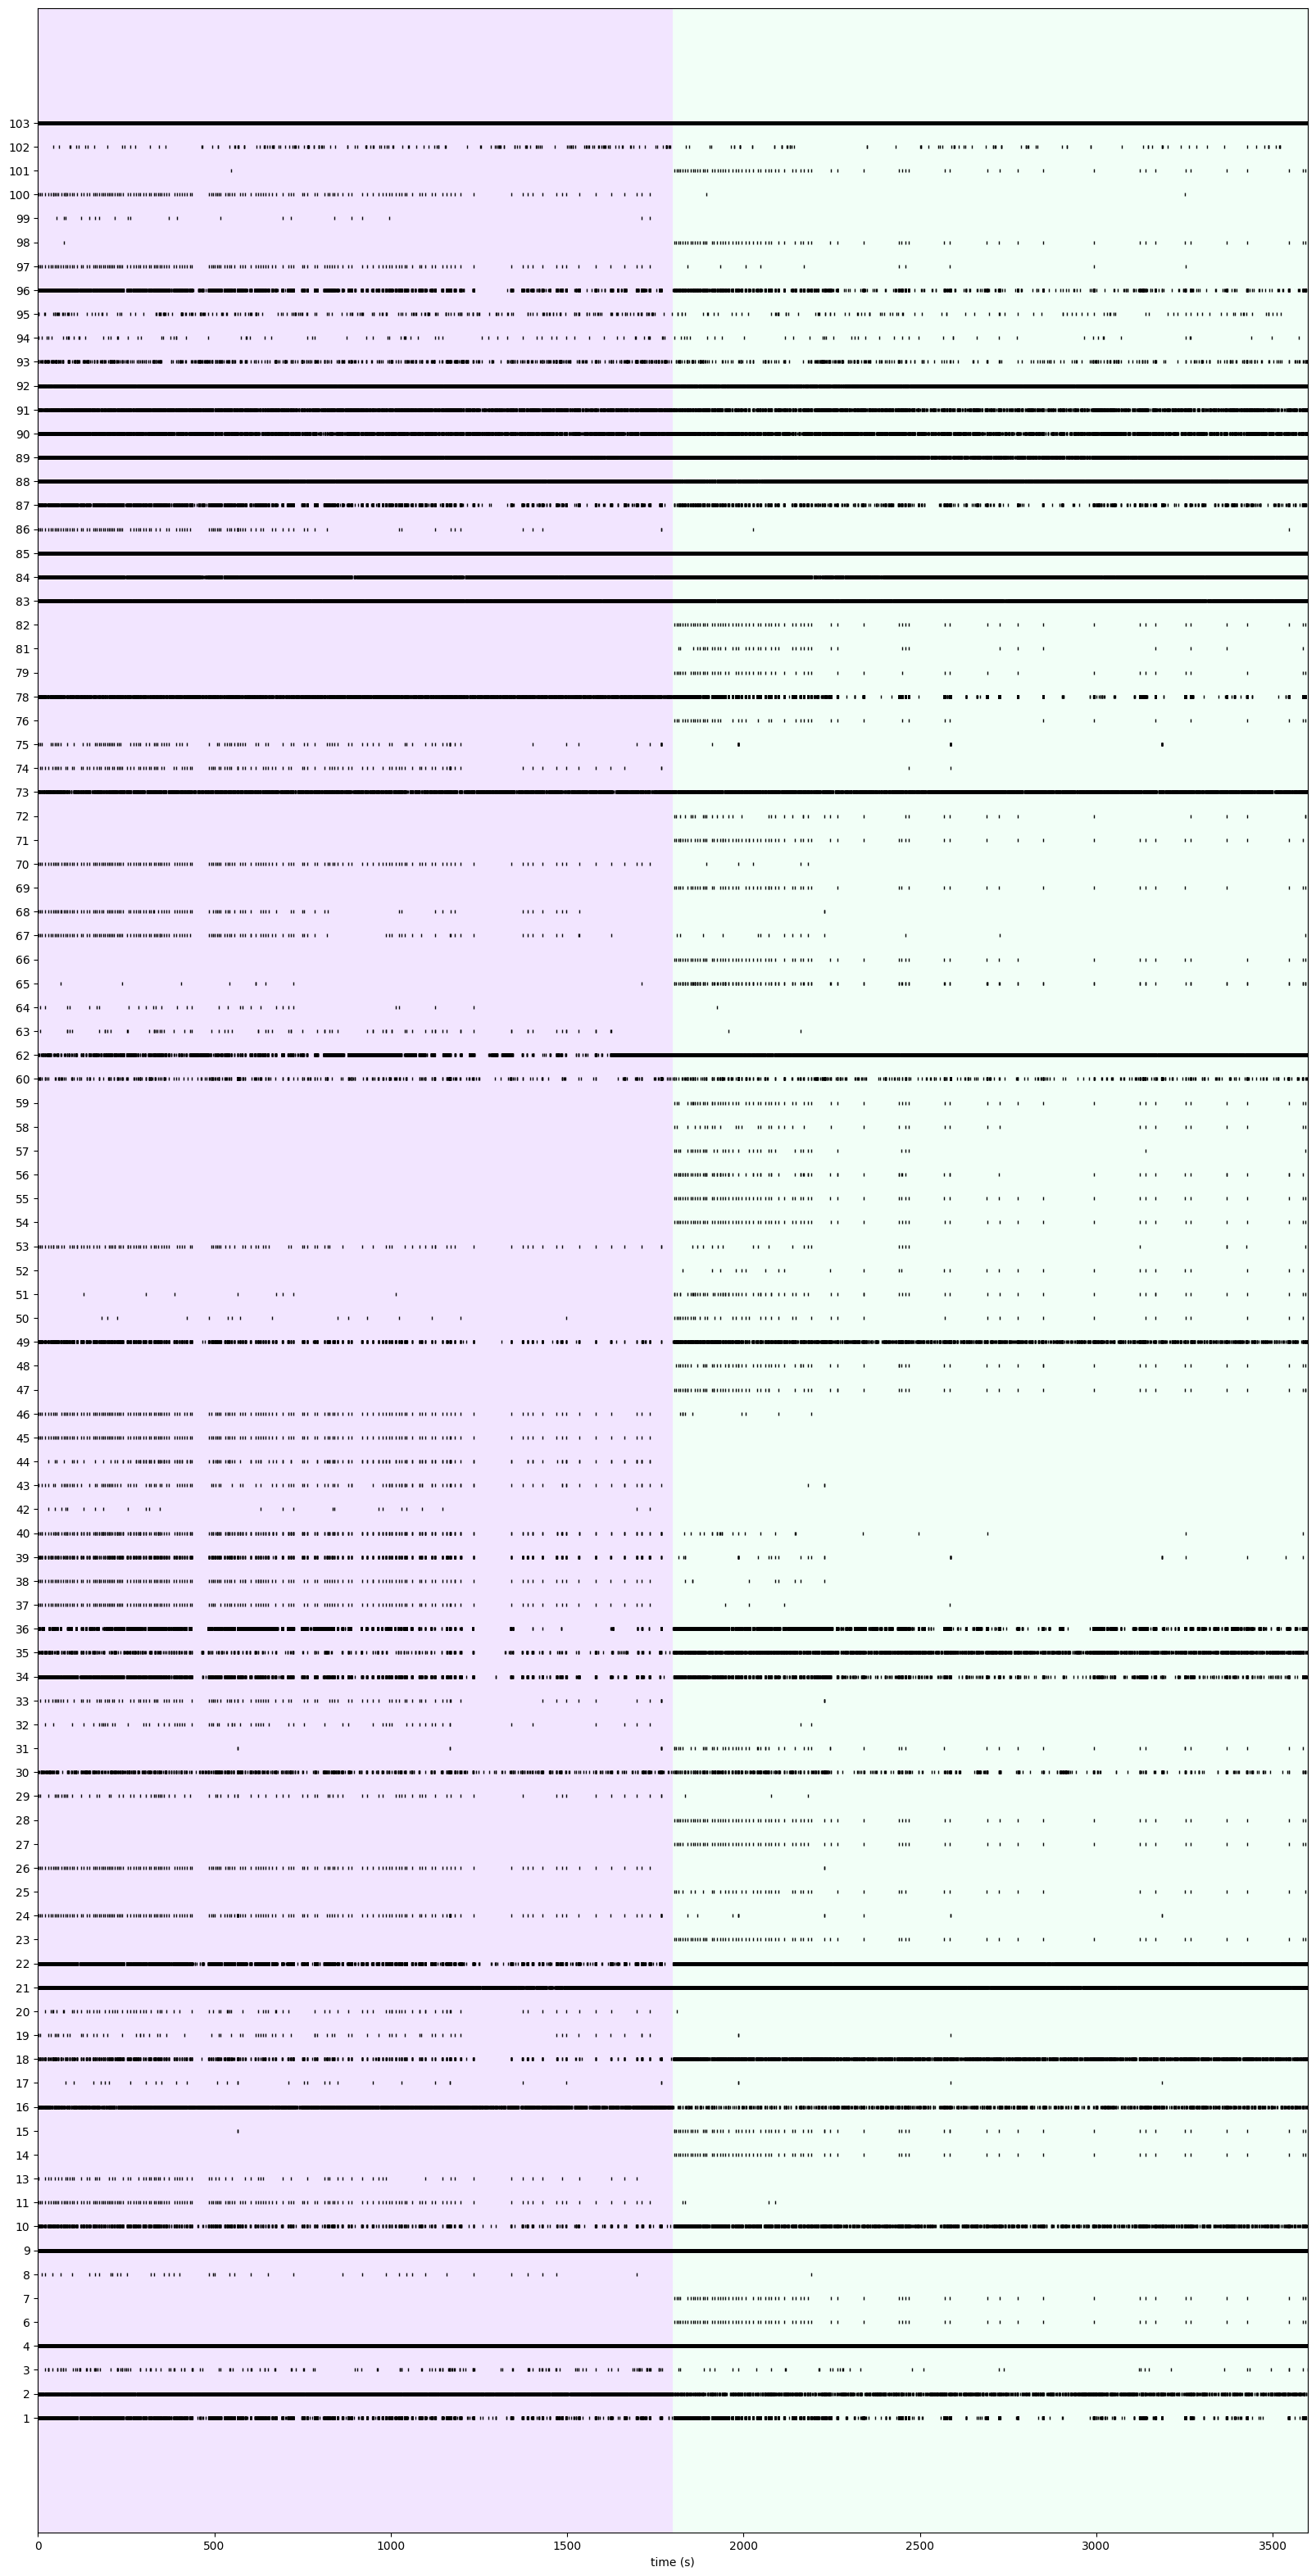

<Figure size 640x480 with 0 Axes>

In [17]:
we.recording.set_probe(mesh_probe, in_place=True)
sorting_day_split(sorting, date_id_all, day_length, pack_folder, 
                  sorting_save_name='firings_inlier')



/home/jialiulab/.conda/envs/MEArec/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


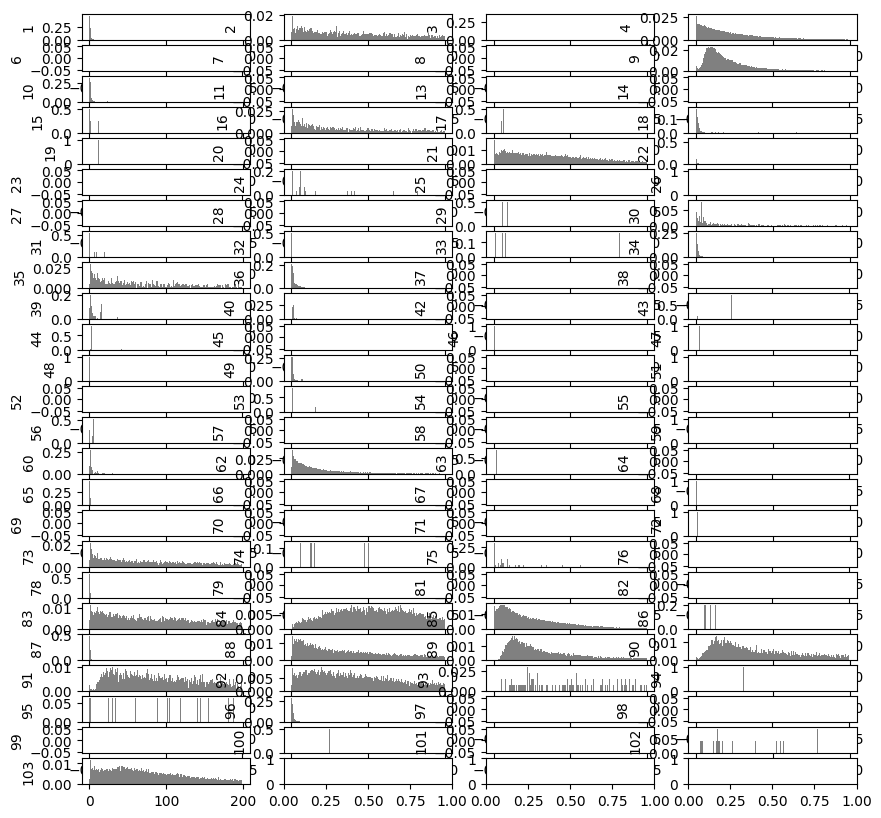

In [18]:
fig,ax = plt.subplots(int(ceil(sorting.unit_ids.shape[0]/4)),4,figsize=(10,10))
sw.plot_isi_distribution(sorting, window_ms=200.0, bin_ms=1.0,axes=ax)

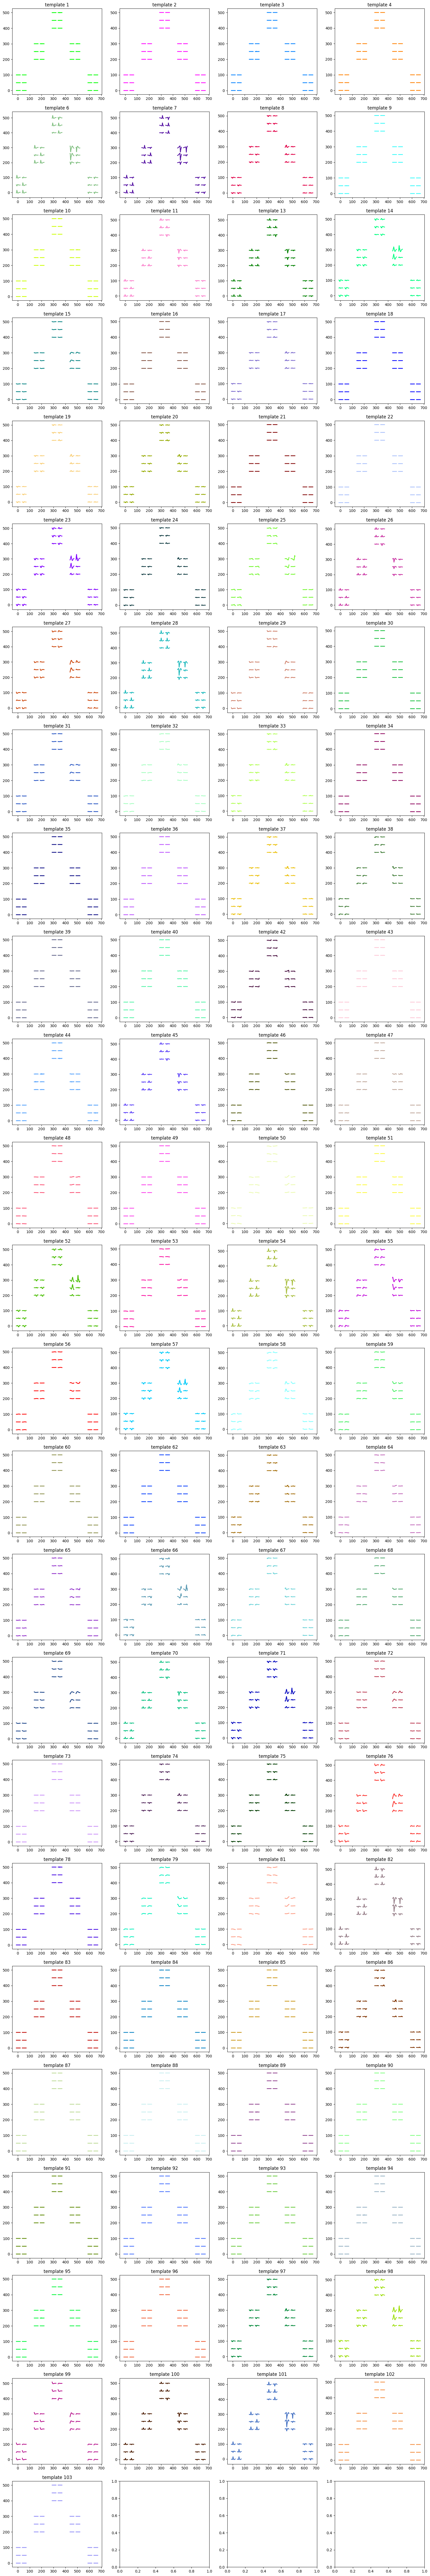

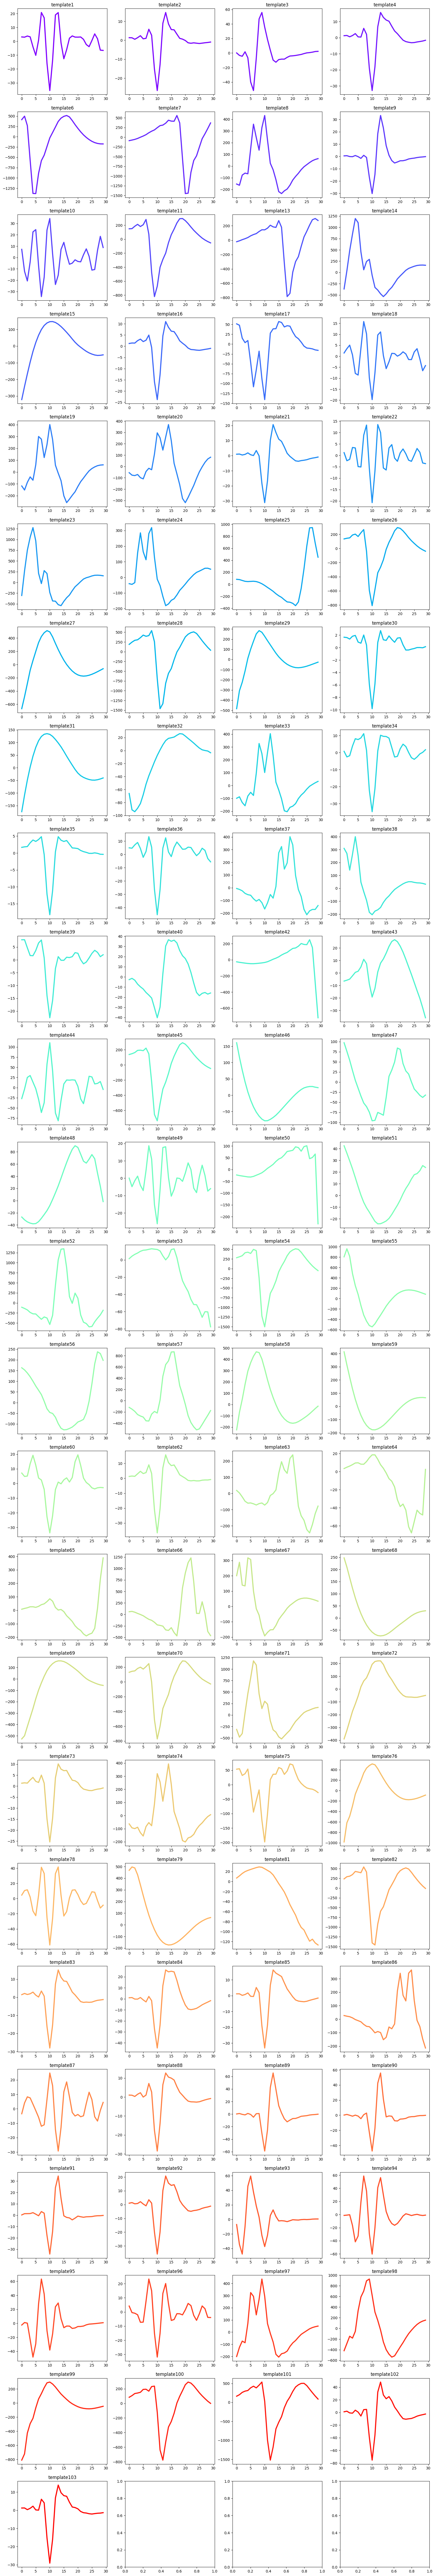

In [19]:
we._template_cache={}
sorting_unit_show(we, recording_cmr, sorting, pack_folder,waveform_folder)

#### Through ISI, waveform characteristics and spiking patterns, we keep units ID 2,4,9,16,21,30,35,62,73,83,84,85,88,89,90,91,92,103.

In [20]:
x=list(np.arange(1,np.max(sorting.unit_ids)+1))
y=[2,4,9,16,21,30,35,62,73,83,84,85,88,89,90,91,92,103]
left = [item for item in x if item not in y]

merge_unit_ids_pack = [] 
delete_unit_ids_pack = left
we_load_if_exists = True
waveform_show = False
input_state = 'merged'

curation_save_folder = pack_folder + f'/curation_result_{input_state}/'
if os.path.exists(curation_save_folder)==False:
    os.mkdir(curation_save_folder)

sorting,we = units_merge(recording_cmr, sorting, merge_unit_ids_pack, delete_unit_ids_pack,pack_folder, True)

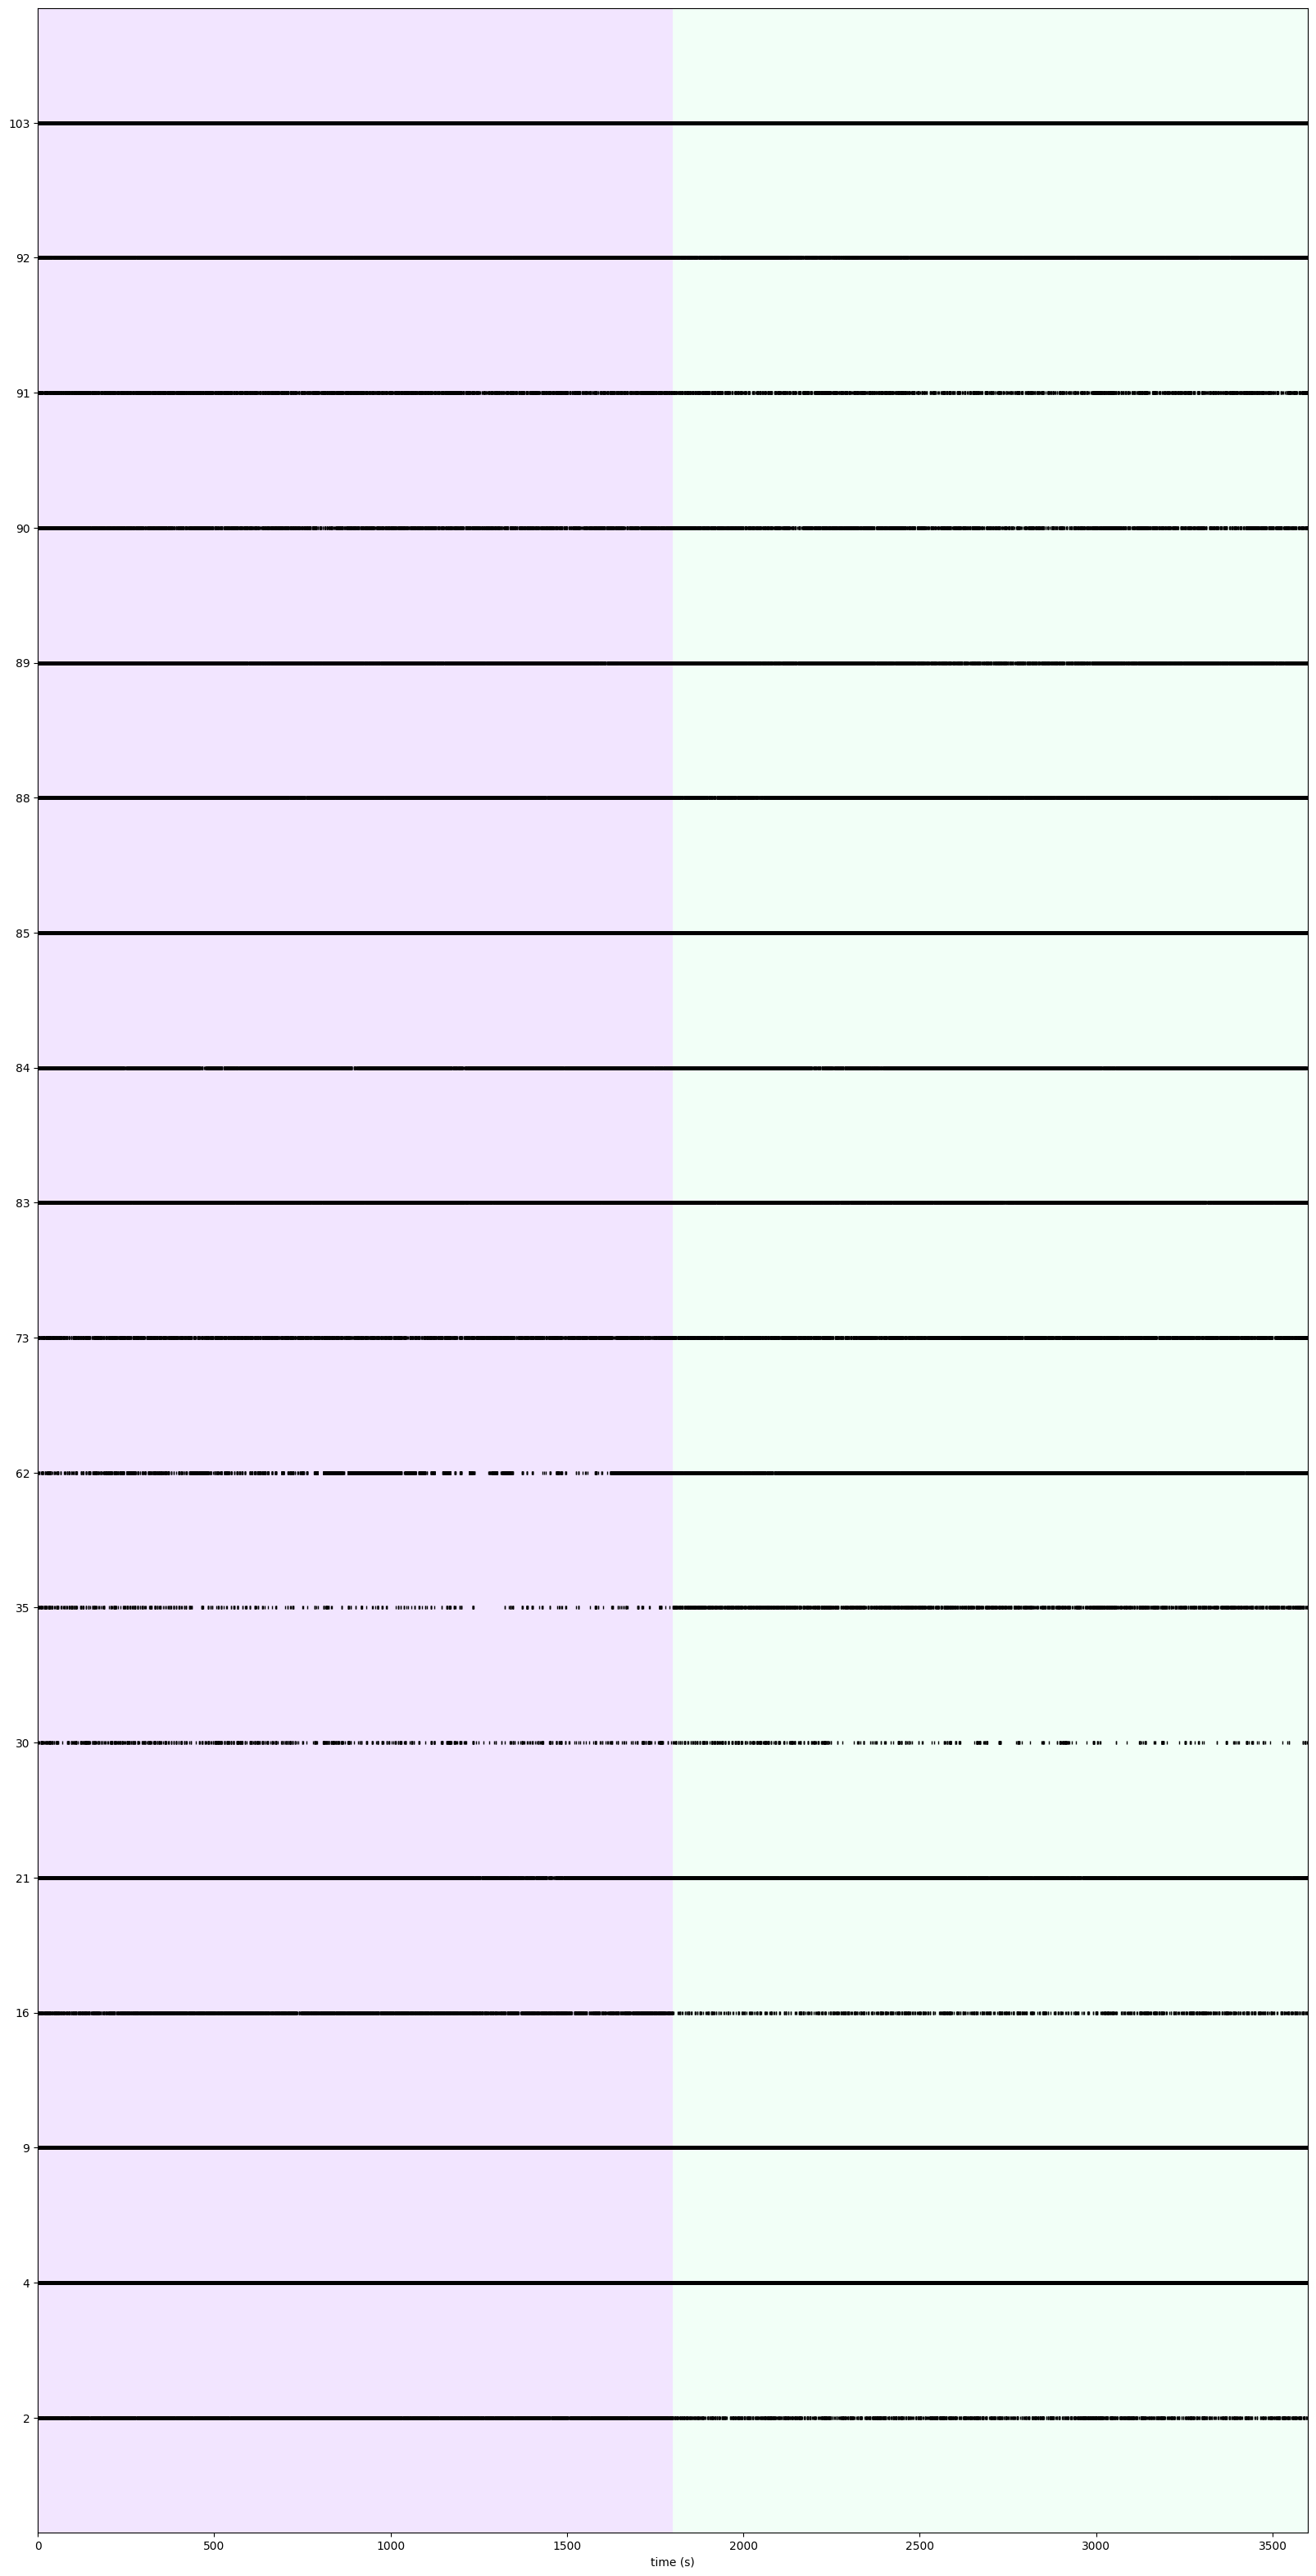

<Figure size 640x480 with 0 Axes>

In [23]:
sorting_day_split(sorting, date_id_all, day_length, pack_folder, 
                  sorting_save_name='firings_merged')

#### We extract waveforms and the extremum channel of curated units.

In [24]:
we._template_cache=[]
we.run_extract_waveforms()

probe_groups = np.arange(0,30)
NUmShanks = 30
we_load_if_exists = True

extremum_channels_ids = st.get_template_extremum_channel(we, peak_sign='neg')

pd.DataFrame.from_dict(extremum_channels_ids, orient='index').to_csv(pack_folder+'extremum_channels_ids.csv')

#### Plot waveforms and ISI of curated units.

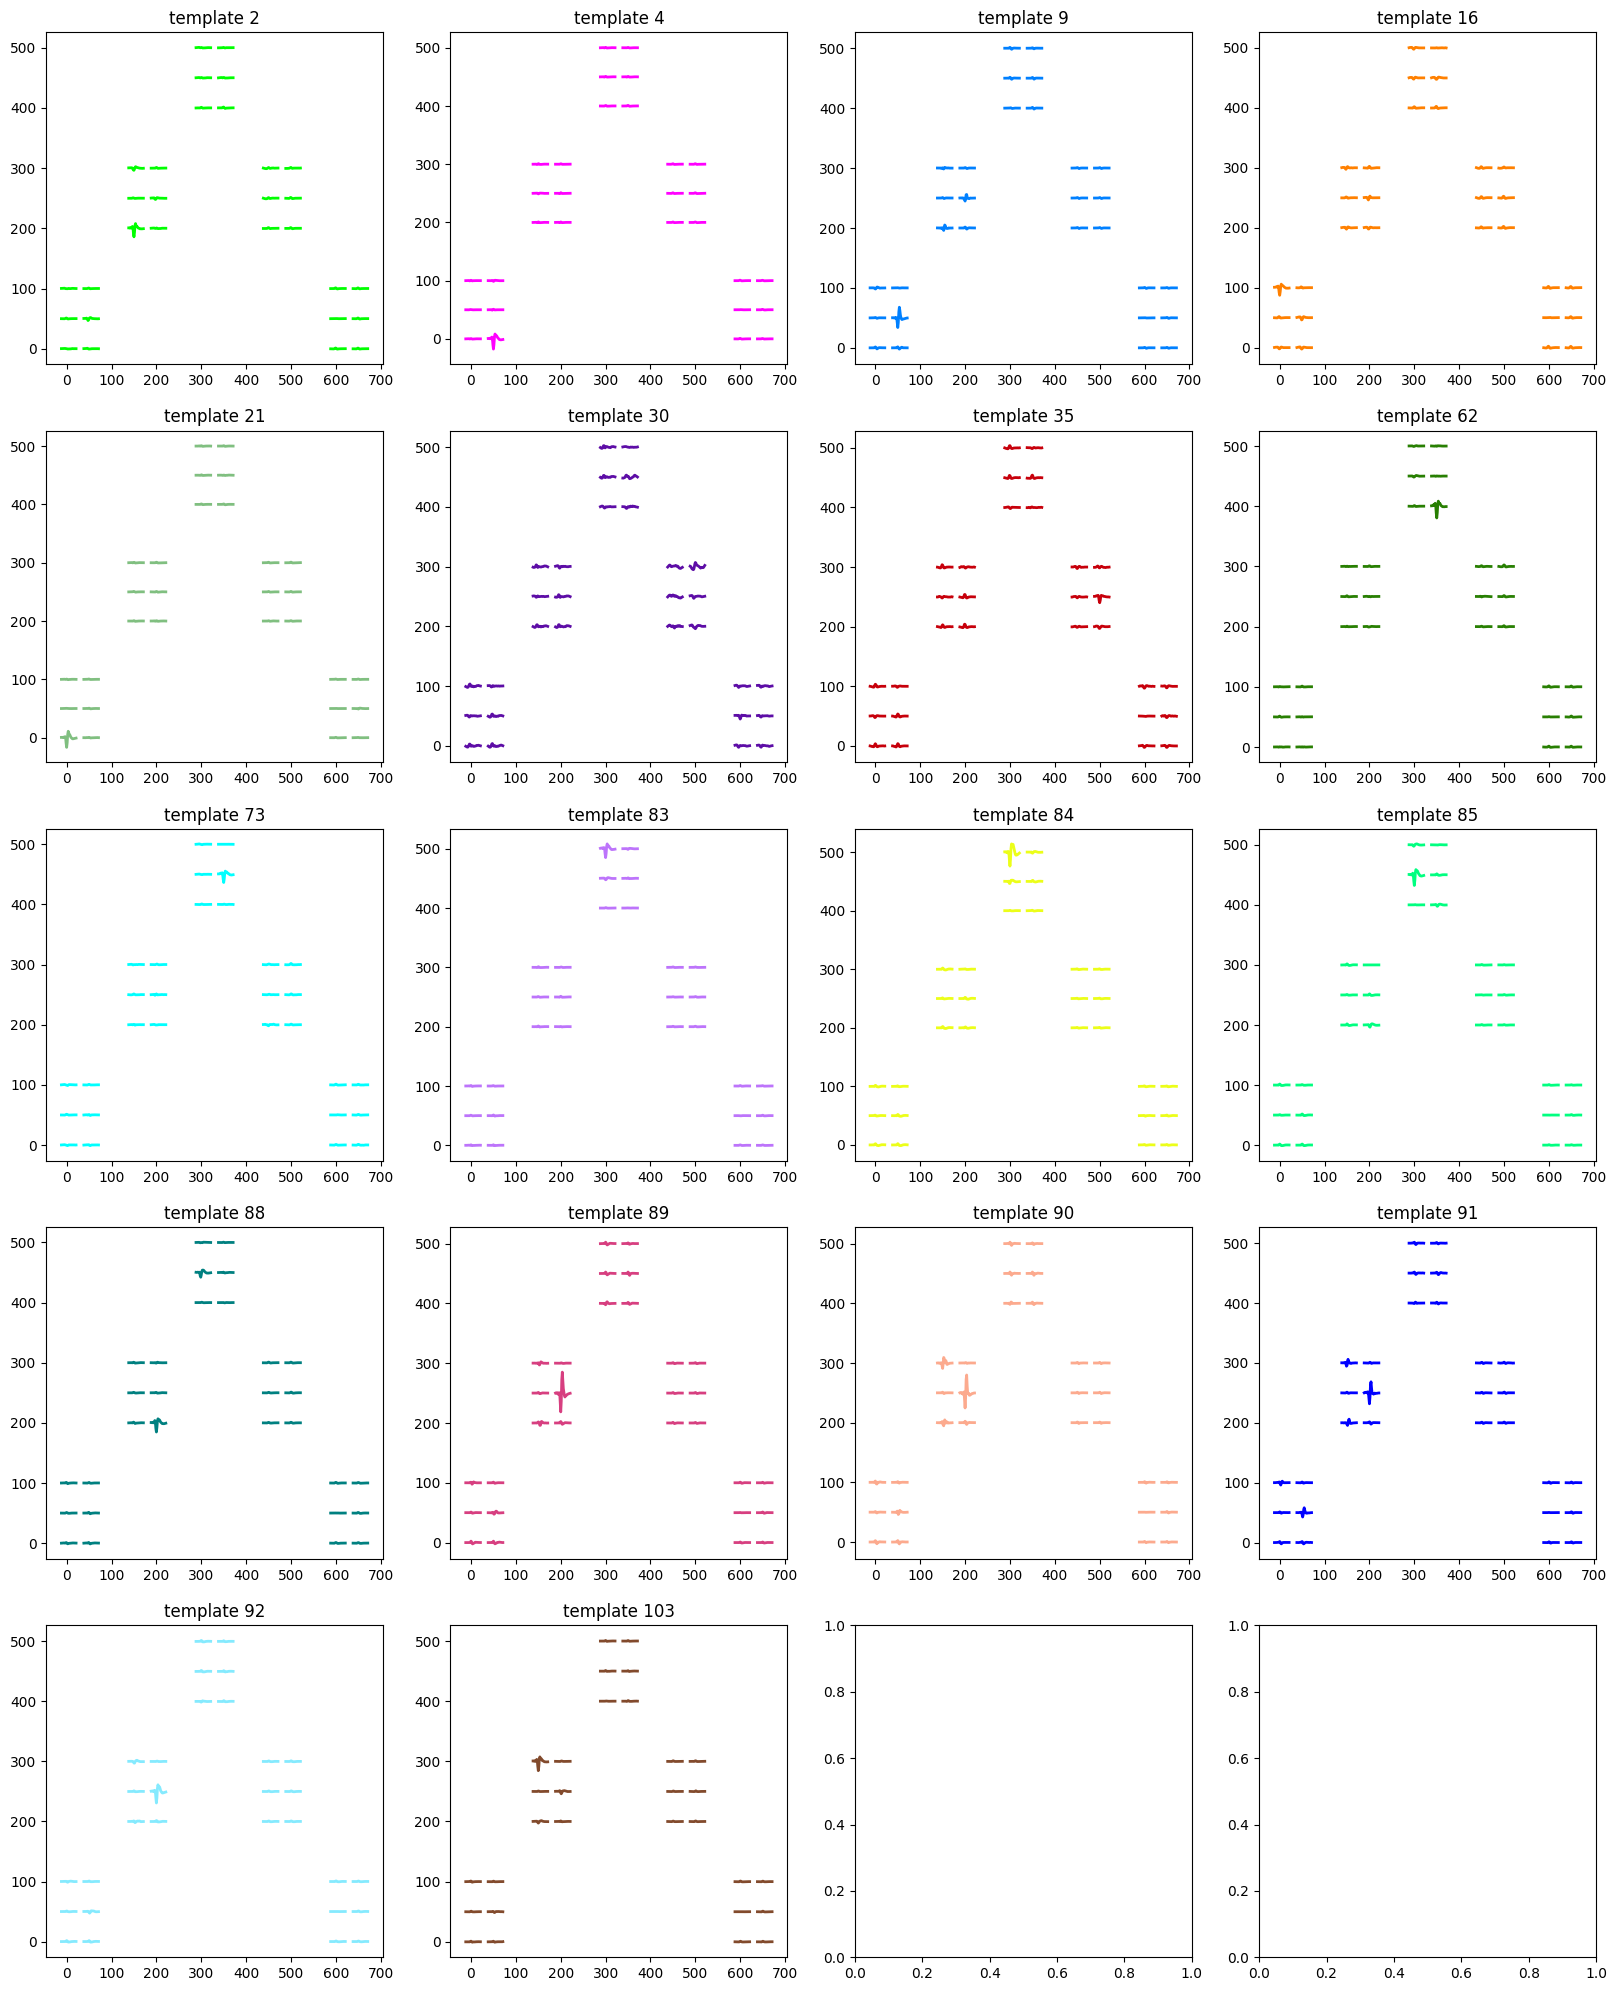

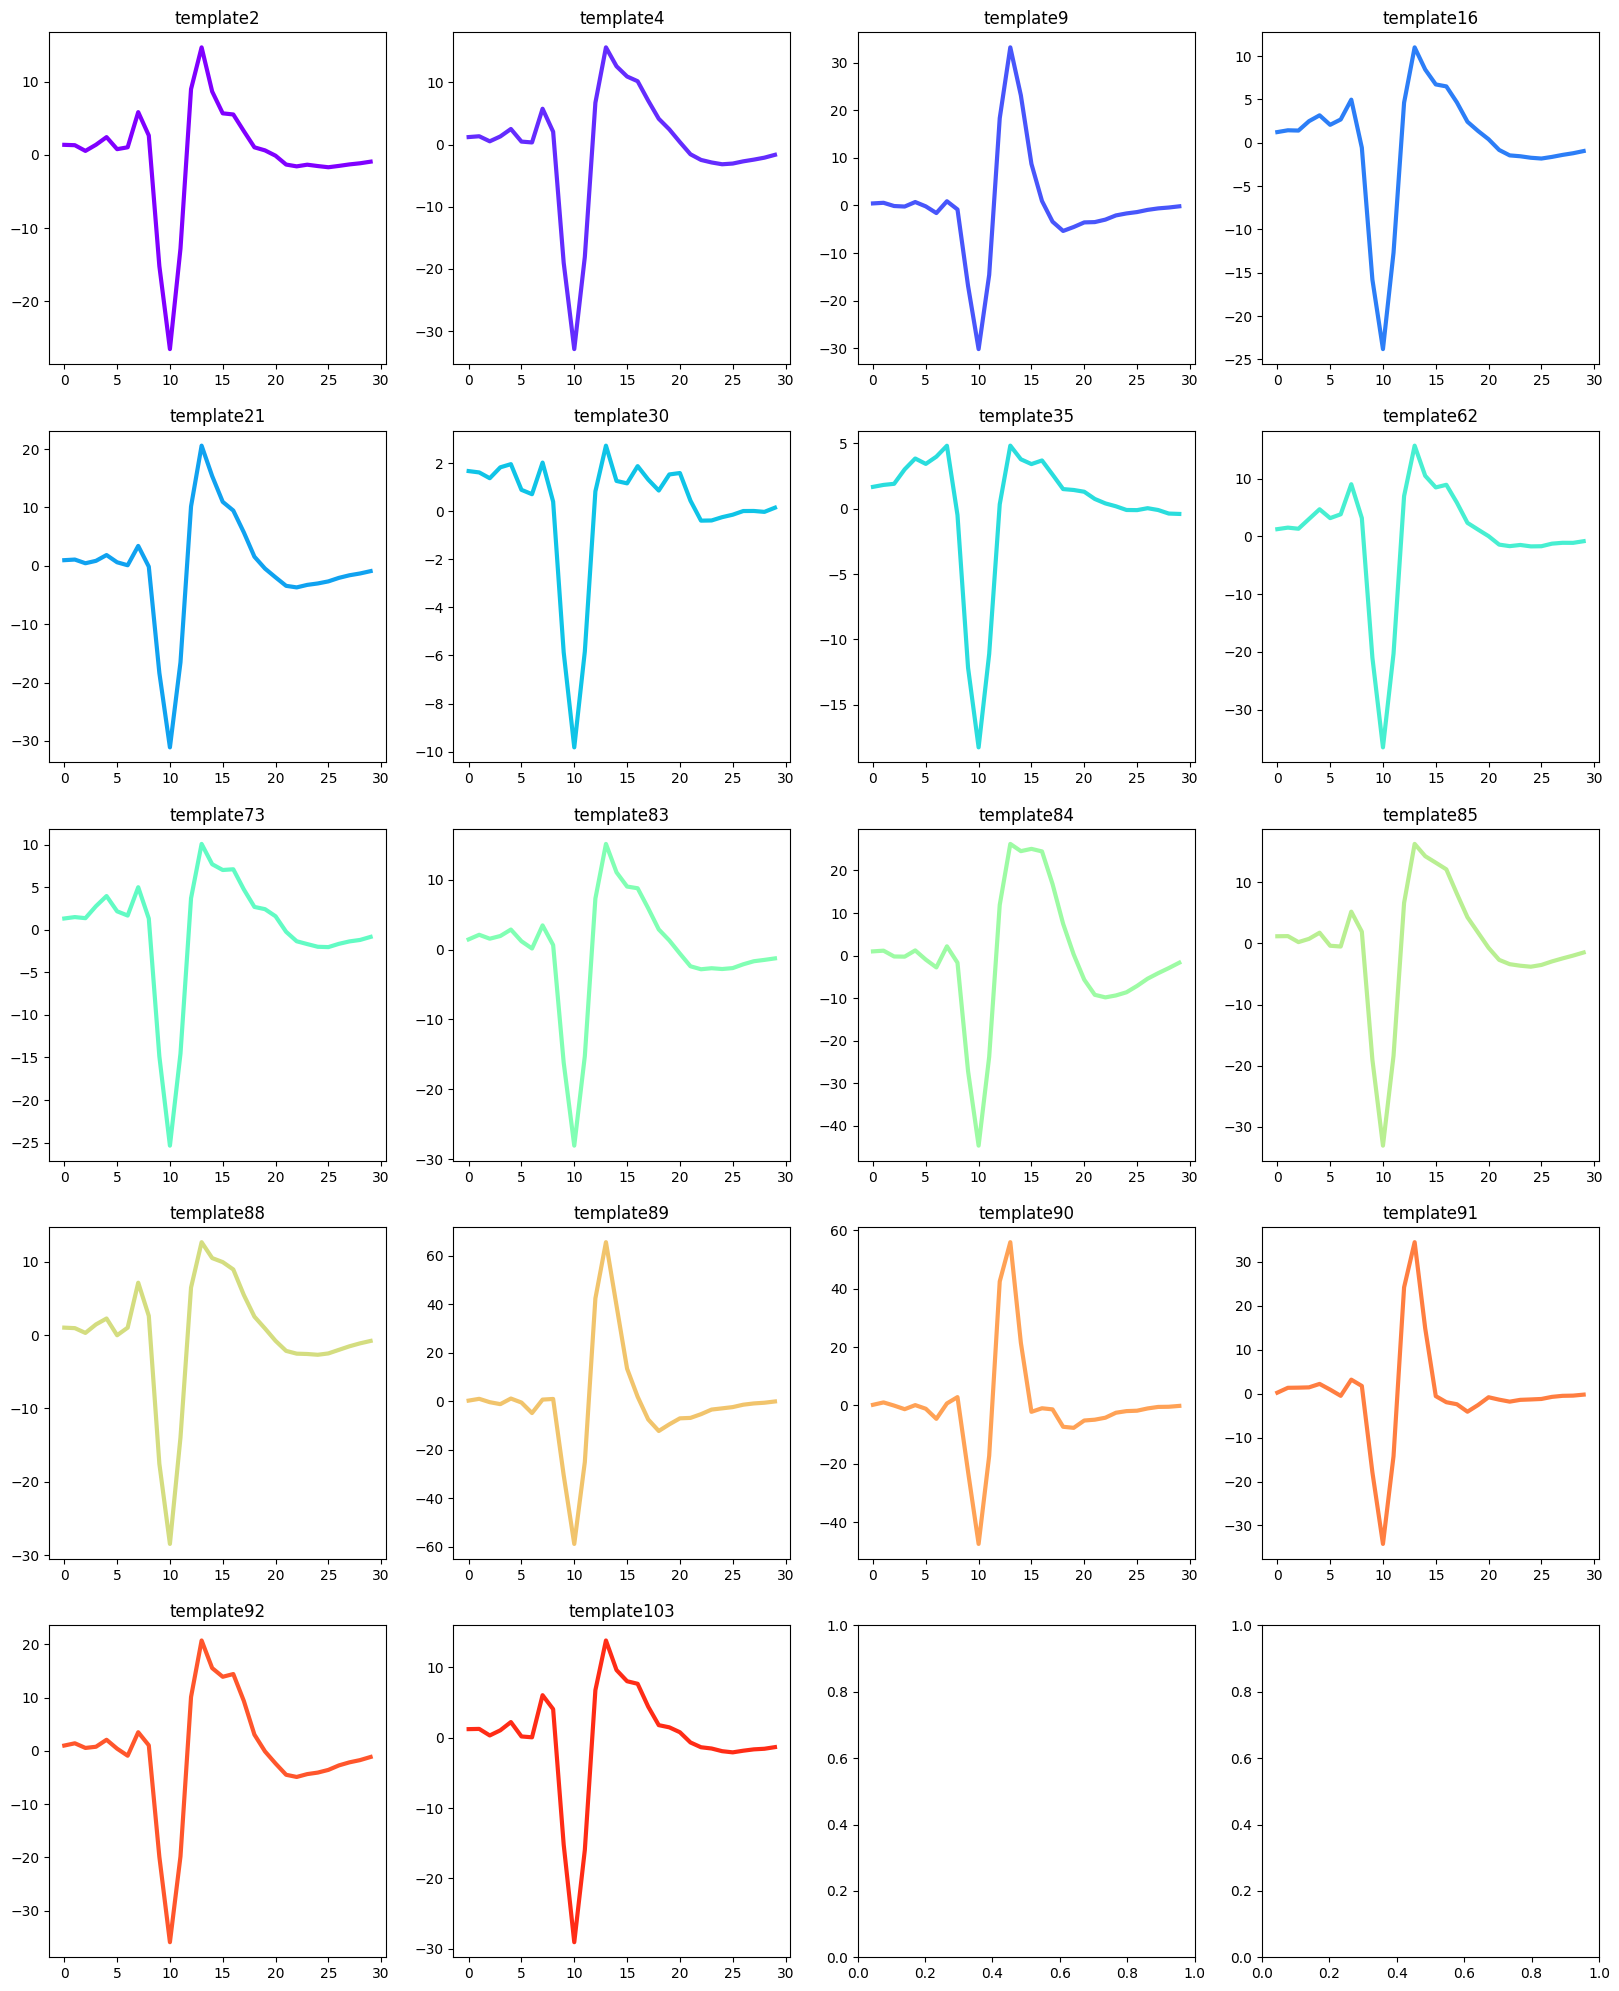

In [26]:
we._template_cache={}
sorting_unit_show(we, recording_cmr, sorting, pack_folder,waveform_folder)

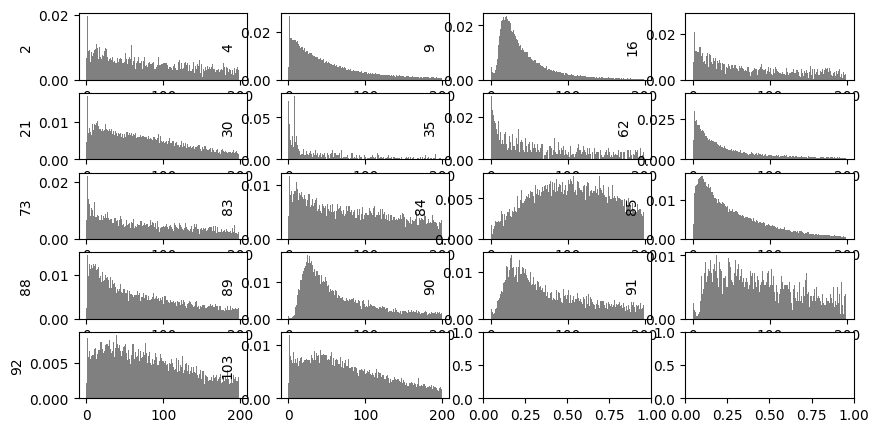

In [25]:

fig,ax = plt.subplots(int(ceil(sorting.unit_ids.shape[0]/4)),4,figsize=(10,5))
sw.plot_isi_distribution(sorting, window_ms=200.0, bin_ms=1.0,axes=ax)


### Now, we can reformat information of sorted spikes as input for AutoSort

In [4]:
date_id_all=['0411','0416'] 
save_pth = './AutoSort_data/'
day_pth = './processed_data/'
raw_data_path = './raw_data/'

freq_max=3000
freq_min=300

left_sample=10
right_sample=20


In [5]:
generate_autosort_input(date_id_all,
                            raw_data_path,
                            save_pth,
                            day_pth,
                            left_sample,
                            right_sample,
                            freq_min,
                            freq_max,
                            mesh_probe
                            )

The input to AutoSort is under the folder './AutoSort_data/'

### With input to AutoSort, we can train a AutoSort model.

In [4]:
### group ID of each electrode 1,2,3...
electrode_group=[1, 1, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1]
electrode_position=np.hstack([positions,np.array(electrode_group).reshape(-1,1)])

Set parameters of AutoSort

In [8]:
args=config()
args.day_id_str=['0411','0416'] ### all days
args.cluster_path='./AutoSort_data/' ### path of input data
args.set_time=0  ### set 0411 data as training data
args.test_time=[1] ### set 0416 data as testing data
args.group=np.arange(30)  ### all electrodes
args.samplepoints=left_sample+right_sample ### 30 points for each waveform
args.sensor_positions_all=electrode_position

In [9]:
run(args)

---------------------------------- SEED ALL ---------------------------------- 
                           Seed Num :   0                                
---------------------------------- SEED ALL ---------------------------------- 
pred_location (1563742, 3)
pred_location (1389635, 3)


100%|██████████| 2715/2715 [00:35<00:00, 77.43it/s]


The trained model is saved in './AutoSort_data/model_save/train_day0411_0/train_weight'.

We will load it for spike sorting of later-stage recordings.

We read the training and testing log to check results.

In [11]:
training_log=pd.read_csv('/n/holystore01/LABS/jialiu_lab/Users/yichunhe/AutoSort/AutoSort_data/model_save/train_day0411_0/train_weight/training_log.csv')

test_log=pd.read_csv('/n/holystore01/LABS/jialiu_lab/Users/yichunhe/AutoSort/AutoSort_data/model_save/train_day0411_0/train_weight/test_log.csv')

In [13]:
training_log

Unnamed: 0  epoch  training_loss1  training_loss2  training_loss3  \
0            0      1             0.0       88.236640      636.867670   
1            1      2             0.0       55.252407      525.652855   
2            2      3             0.0       49.897838      416.135145   
3            3      4             0.0       45.031538      329.046193   
4            4      5             0.0       39.110140      252.455911   
5            5      6             0.0       32.167068      200.908436   
6            6      7             0.0       25.162607      170.545233   
7            7      8             0.0       18.493239      153.587542   
8            8      9             0.0       13.463344      139.292859   
9            9     10             0.0        9.998796      131.525234   
10          10     11             0.0        8.224920      123.764675   
11          11     12             0.0        7.623227      116.968840   
12          12     13             0.0        6.486889      111.543438   
13          13     14             0.0        5.718241      104.000065   
14          14     15             0.0        5.484002      100.119686   
15          15     16             0.0        5.301268       97.600013   
16          16     17             0.0        4.380280       91.148396   
17          17     18             0.0        4.679176       88.565699   
18          18     19             0.0        3.952477       80.395939   
19          19     20             0.0        3.767373       76.914131   

    validation_loss1  validation_loss2  validation_loss3  \
0                0.0          0.024423          0.832188   
1                0.0          0.029636          0.727979   
2                0.0          0.022134          0.706065   
3                0.0          0.030280          0.441125   
4                0.0          0.014190          0.331097   
5                0.0          0.018099          0.267207   
6                0.0          0.020679          0.296758   
7                0.0          0.008097          0.245054   
8                0.0          0.009195          0.195346   
9                0.0          0.010384          0.198549   
10               0.0          0.002602          0.174814   
11               0.0          0.010504          0.201797   
12               0.0          0.005386          0.139402   
13               0.0          0.001681          0.151564   
14               0.0          0.003435          0.144267   
15               0.0          0.003823          0.106873   
16               0.0          0.007723          0.161709   
17               0.0          0.005026          0.108531   
18               0.0          0.010015          0.153592   
19               0.0          0.016114          0.194808   

    validation_acc_noise  validation_acc_label  \
0               0.995249              0.422782   
1               0.995949              0.484658   
2               0.996112              0.608976   
3               0.994504              0.688640   
4               0.996058              0.753853   
5               0.995485              0.784904   
6               0.994820              0.779644   
7               0.994945              0.795537   
8               0.992655              0.814287   
9               0.994161              0.806623   
10              0.994609              0.819010   
11              0.993340              0.817567   
12              0.994993              0.820876   
13              0.994820              0.820480   
14              0.994392              0.814485   
15              0.992790              0.828964   
16              0.993269              0.826900   
17              0.994363              0.832697   
18              0.995671              0.818953   
19              0.994804              0.828512   

    validation_acc_noise_unbalanced  validation_acc_label_unbalanced  \
0                          0.984688                         0.289304   
1             

In [12]:
test_log

Unnamed: 0  train_time  timepoint  noise_acc  label_acc  \
0           0         411        416   0.996218   0.865962   

   noise_acc_unbalanced  label_acc_unbalanced  
0              0.882873              0.790365